In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=== Fraud Detection: K-Means Clustering (Unsupervised) ===")
print("=" * 50)

# STEP 1: Load and Prepare Data
print("\n1. Loading and preparing data...")

# Load the cleaned data
df = pd.read_csv('data/processed/cc_cleaned.csv')
print(f"Dataset shape: {df.shape}")

# Separate features for clustering (exclude Class for unsupervised learning)
# Use PCA features (V1-V28) and Amount for clustering
v_features = [f'V{i}' for i in range(1, 29)]
features_for_clustering = v_features + ['Amount', 'Time']

X = df[features_for_clustering]
y = df['Class']  # Keep for evaluation only

print(f"Using {len(features_for_clustering)} features for clustering: {features_for_clustering}")
print(f"Class distribution (for evaluation): {y.value_counts().to_dict()}")


=== Fraud Detection: K-Means Clustering (Unsupervised) ===

1. Loading and preparing data...
Dataset shape: (281918, 34)
Using 30 features for clustering: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Time']
Class distribution (for evaluation): {0: 281470, 1: 448}


In [3]:
# STEP 2: Scale Features
print("\n2. Scaling features for K-Means...")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features scaled using StandardScaler")
print(f"Scaled data shape: {X_scaled.shape}")


2. Scaling features for K-Means...
Features scaled using StandardScaler
Scaled data shape: (281918, 30)



3. Determining optimal number of clusters...
Optimal K found: 5


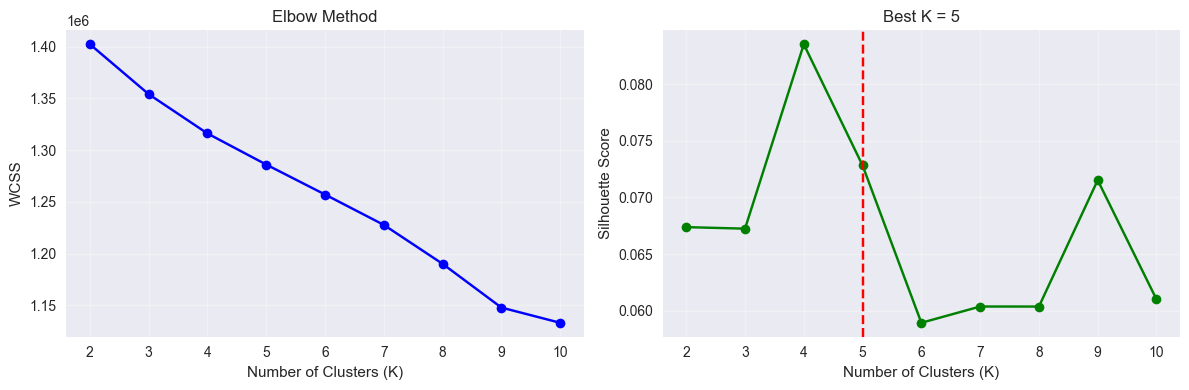


4. Fitting K-Means with K=5 on full dataset...


In [5]:
# STEP 3: Determine Optimal Number of Clusters (K)
print("\n3. Determining optimal number of clusters...")

# Fast method: Use 20% sample for K selection
sample_size = 50000
np.random.seed(42)
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_indices]

K_range = range(2, 11)
wcss = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=3)
    kmeans.fit(X_sample)
    wcss.append(kmeans.inertia_)
    
    if k > 1:
        silhouette_avg = silhouette_score(X_sample, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)

# Find best K
best_k_idx = np.argmax(silhouette_scores) + 1
optimal_k = K_range[best_k_idx]

print(f"Optimal K found: {optimal_k}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(K_range, wcss, 'bo-')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('WCSS')
axes[0].set_title('Elbow Method')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores, 'go-')
axes[1].axvline(optimal_k, color='red', linestyle='--')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title(f'Best K = {optimal_k}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Fit final model with optimal K on full data
print(f"\n4. Fitting K-Means with K={optimal_k} on full dataset...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

In [6]:
# STEP 4: Apply K-Means with Optimal K
print(f"\n4. Applying K-Means with K={optimal_k}...")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)
cluster_centers = kmeans.cluster_centers_

print("K-Means clustering completed")
print(f"Cluster sizes: {np.bincount(cluster_labels)}")

# Add cluster labels to dataframe
df['Cluster'] = cluster_labels
df['Distance_to_Centroid'] = np.min(kmeans.transform(X_scaled), axis=1)



4. Applying K-Means with K=5...
K-Means clustering completed
Cluster sizes: [  3512 109451 127288   4039  37628]


In [7]:
# STEP 5: Analyze Cluster Characteristics
print("\n5. Analyzing cluster characteristics...")

# Create cluster statistics
cluster_stats = []
for cluster_id in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster_id]
    
    stats = {
        'Cluster': cluster_id,
        'Size': len(cluster_data),
        'Size_Percent': len(cluster_data) / len(df) * 100,
        'Fraud_Count': cluster_data['Class'].sum(),
        'Fraud_Rate': cluster_data['Class'].mean() * 100,
        'Avg_Amount': cluster_data['Amount'].mean(),
        'Avg_Distance': cluster_data['Distance_to_Centroid'].mean(),
        'Std_Distance': cluster_data['Distance_to_Centroid'].std()
    }
    cluster_stats.append(stats)

cluster_stats_df = pd.DataFrame(cluster_stats)
cluster_stats_df = cluster_stats_df.sort_values('Fraud_Rate', ascending=False)

print("\nCluster Statistics (sorted by Fraud Rate):")
print("=" * 80)
print(cluster_stats_df.round(4))

# Identify suspicious clusters (high fraud rate or small size)
suspicious_clusters = cluster_stats_df[
    (cluster_stats_df['Fraud_Rate'] > cluster_stats_df['Fraud_Rate'].median()) |
    (cluster_stats_df['Size_Percent'] < 1)  # Clusters smaller than 1% of data
]

print(f"\n⚠ Suspicious clusters identified: {len(suspicious_clusters)}")
print("Suspicious clusters (high fraud rate or very small):")
print(suspicious_clusters[['Cluster', 'Size', 'Fraud_Rate', 'Avg_Distance']])



5. Analyzing cluster characteristics...

Cluster Statistics (sorted by Fraud Rate):
   Cluster    Size  Size_Percent  Fraud_Count  Fraud_Rate  Avg_Amount  \
0        0    3512        1.2458           34      0.9681     -0.2694   
3        3    4039        1.4327           11      0.2723      5.8415   
2        2  127288       45.1507          237      0.1862     -0.1022   
1        1  109451       38.8237          162      0.1480     -0.1261   
4        4   37628       13.3471            4      0.0106      0.1105   

   Avg_Distance  Std_Distance  
0        8.2945        5.0412  
3        9.4681        9.1725  
2        4.2737        2.2670  
1        4.3724        2.0482  
4        4.3166        1.7008  

⚠ Suspicious clusters identified: 2
Suspicious clusters (high fraud rate or very small):
   Cluster  Size  Fraud_Rate  Avg_Distance
0        0  3512    0.968109      8.294547
3        3  4039    0.272345      9.468085


In [8]:
# STEP 6: Calculate Anomaly Scores
print("\n6. Calculating anomaly scores...")

# Method 1: Distance-based anomaly score
df['Anomaly_Score_Distance'] = df['Distance_to_Centroid'] / df['Distance_to_Centroid'].max()

# Method 2: Small cluster penalty
cluster_sizes = df['Cluster'].value_counts()
df['Anomaly_Score_Size'] = 1 - (cluster_sizes[df['Cluster']].values / cluster_sizes.max())

# Method 3: Combined anomaly score
df['Anomaly_Score_Combined'] = 0.6 * df['Anomaly_Score_Distance'] + 0.4 * df['Anomaly_Score_Size']

# Normalize scores to 0-1 range
df['Anomaly_Score_Combined'] = (df['Anomaly_Score_Combined'] - df['Anomaly_Score_Combined'].min()) / \
                               (df['Anomaly_Score_Combined'].max() - df['Anomaly_Score_Combined'].min())
print("✓ Anomaly scores calculated:")
print(f"  • Distance-based score (0-1)")
print(f"  • Small-cluster penalty score (0-1)")
print(f"  • Combined score (0-1, weighted average)")



6. Calculating anomaly scores...
✓ Anomaly scores calculated:
  • Distance-based score (0-1)
  • Small-cluster penalty score (0-1)
  • Combined score (0-1, weighted average)



7. Visualizing clusters...


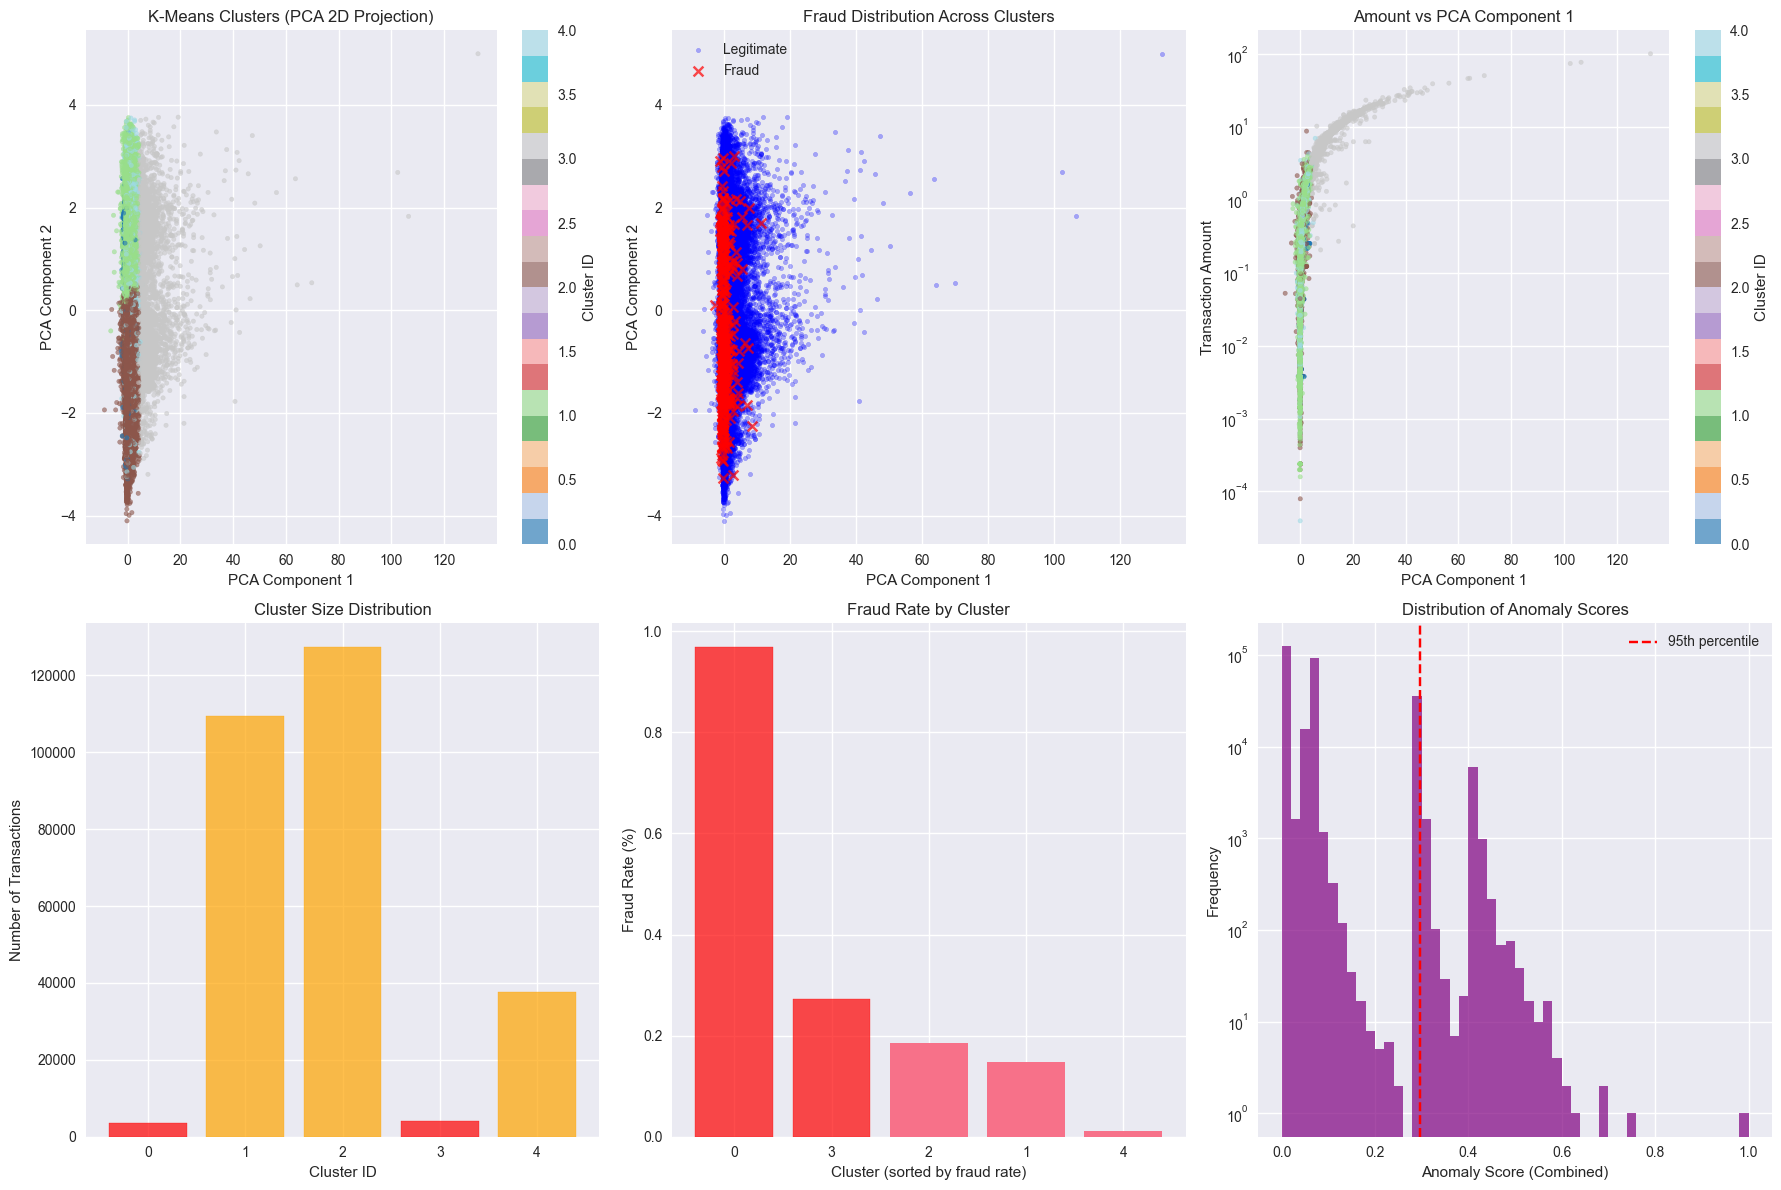

In [9]:
# STEP 7: Visualize Clusters
print("\n7. Visualizing clusters...")

# Reduce to 2D using PCA for visualization
pca_2d = PCA(n_components=2, random_state=42)
X_pca = pca_2d.fit_transform(X_scaled)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: PCA 2D Scatter with Cluster Colors
scatter1 = axes[0,0].scatter(df['PCA1'], df['PCA2'], c=df['Cluster'], 
                            cmap='tab20', alpha=0.6, s=10)
axes[0,0].set_xlabel('PCA Component 1')
axes[0,0].set_ylabel('PCA Component 2')
axes[0,0].set_title('K-Means Clusters (PCA 2D Projection)')
plt.colorbar(scatter1, ax=axes[0,0], label='Cluster ID')

# Plot 2: PCA 2D with Fraud Overlay
fraud_mask = df['Class'] == 1
axes[0,1].scatter(df.loc[~fraud_mask, 'PCA1'], df.loc[~fraud_mask, 'PCA2'], 
                  alpha=0.3, s=10, label='Legitimate', color='blue')
axes[0,1].scatter(df.loc[fraud_mask, 'PCA1'], df.loc[fraud_mask, 'PCA2'], 
                  alpha=0.7, s=50, label='Fraud', color='red', marker='x')
axes[0,1].set_xlabel('PCA Component 1')
axes[0,1].set_ylabel('PCA Component 2')
axes[0,1].set_title('Fraud Distribution Across Clusters')
axes[0,1].legend()

# Plot 3: Amount vs PCA1 by Cluster
scatter3 = axes[0,2].scatter(df['PCA1'], df['Amount'], c=df['Cluster'], 
                            cmap='tab20', alpha=0.6, s=10)
axes[0,2].set_xlabel('PCA Component 1')
axes[0,2].set_ylabel('Transaction Amount')
axes[0,2].set_title('Amount vs PCA Component 1')
axes[0,2].set_yscale('log')
plt.colorbar(scatter3, ax=axes[0,2], label='Cluster ID')

# Plot 4: Cluster Size Distribution
cluster_sizes = df['Cluster'].value_counts().sort_index()
bars = axes[1,0].bar(range(optimal_k), cluster_sizes.values)
axes[1,0].set_xlabel('Cluster ID')
axes[1,0].set_ylabel('Number of Transactions')
axes[1,0].set_title('Cluster Size Distribution')
axes[1,0].set_xticks(range(optimal_k))

# Color bars by fraud rate
for i, bar in enumerate(bars):
    fraud_rate = cluster_stats_df[cluster_stats_df['Cluster'] == i]['Fraud_Rate'].values[0]
    if fraud_rate > cluster_stats_df['Fraud_Rate'].median():
        bar.set_color('red')
        bar.set_alpha(0.7)
    elif fraud_rate > 0:
        bar.set_color('orange')
        bar.set_alpha(0.7)

# Plot 5: Fraud Rate by Cluster
bars2 = axes[1,1].bar(range(len(cluster_stats_df)), cluster_stats_df['Fraud_Rate'])
axes[1,1].set_xlabel('Cluster (sorted by fraud rate)')
axes[1,1].set_ylabel('Fraud Rate (%)')
axes[1,1].set_title('Fraud Rate by Cluster')
axes[1,1].set_xticks(range(len(cluster_stats_df)))
axes[1,1].set_xticklabels(cluster_stats_df['Cluster'])

# Color high fraud rate bars
for i, bar in enumerate(bars2):
    if cluster_stats_df.iloc[i]['Fraud_Rate'] > cluster_stats_df['Fraud_Rate'].median():
        bar.set_color('red')
        bar.set_alpha(0.7)

# Plot 6: Anomaly Score Distribution
axes[1,2].hist(df['Anomaly_Score_Combined'], bins=50, alpha=0.7, color='purple')
axes[1,2].axvline(df['Anomaly_Score_Combined'].quantile(0.95), color='red', 
                  linestyle='--', label='95th percentile')
axes[1,2].set_xlabel('Anomaly Score (Combined)')
axes[1,2].set_ylabel('Frequency')
axes[1,2].set_title('Distribution of Anomaly Scores')
axes[1,2].legend()
axes[1,2].set_yscale('log')

plt.tight_layout()
plt.show()

In [10]:
# STEP 8: Evaluate Anomaly Detection Performance
print("\n8. Evaluating anomaly detection performance...")

# Use anomaly score as fraud predictor
thresholds = [0.9, 0.95, 0.99]  # Top 10%, 5%, 1% as anomalies
results = []

for threshold_percentile in thresholds:
    threshold = df['Anomaly_Score_Combined'].quantile(threshold_percentile)
    y_pred = (df['Anomaly_Score_Combined'] >= threshold).astype(int)
    
    # Calculate metrics
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    results.append({
        'Threshold_Percentile': threshold_percentile,
        'Threshold_Value': threshold,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'True_Positives': tp,
        'False_Positives': fp,
        'True_Negatives': tn,
        'False_Negatives': fn,
        'Alerts_Per_Fraud': fp / tp if tp > 0 else np.inf
    })

results_df = pd.DataFrame(results)
print("\nK-Means Anomaly Detection Performance:")
print("=" * 80)
print(results_df.round(4))

# Find best threshold based on F1-score
best_result = results_df.loc[results_df['F1_Score'].idxmax()]
print(f"\n Best threshold: {best_result['Threshold_Percentile']:.0%} percentile")
print(f"   • Precision: {best_result['Precision']:.1%}")
print(f"   • Recall: {best_result['Recall']:.1%}")
print(f"   • F1-Score: {best_result['F1_Score']:.4f}")
print(f"   • Alerts per fraud: {best_result['Alerts_Per_Fraud']:.1f}")



8. Evaluating anomaly detection performance...

K-Means Anomaly Detection Performance:
   Threshold_Percentile  Threshold_Value  Accuracy  Precision  Recall  \
0                  0.90           0.2924    0.8987     0.0017  0.1049   
1                  0.95           0.2963    0.9487     0.0033  0.1049   
2                  0.99           0.4123    0.9887     0.0152  0.0960   

   F1_Score  True_Positives  False_Positives  True_Negatives  False_Negatives  \
0    0.0033              47            28145          253325              401   
1    0.0065              47            14049          267421              401   
2    0.0263              43             2777          278693              405   

   Alerts_Per_Fraud  
0          598.8298  
1          298.9149  
2           64.5814  

 Best threshold: 99% percentile
   • Precision: 1.5%
   • Recall: 9.6%
   • F1-Score: 0.0263
   • Alerts per fraud: 64.6



9. Comparing with supervised models...

Model Comparison (K-Means vs Supervised):
      Metric  K-Means (Unsupervised)  Random Forest  Neural Network  \
0     Recall                  0.0960         0.8556          0.9333   
1  Precision                  0.0152         0.8105          0.0594   
2   F1-Score                  0.0263         0.8324          0.1116   

   Decision Tree  Logistic Regression  
0         0.9222               0.9444  
1         0.0314               0.0540  
2         0.0607               0.1021  


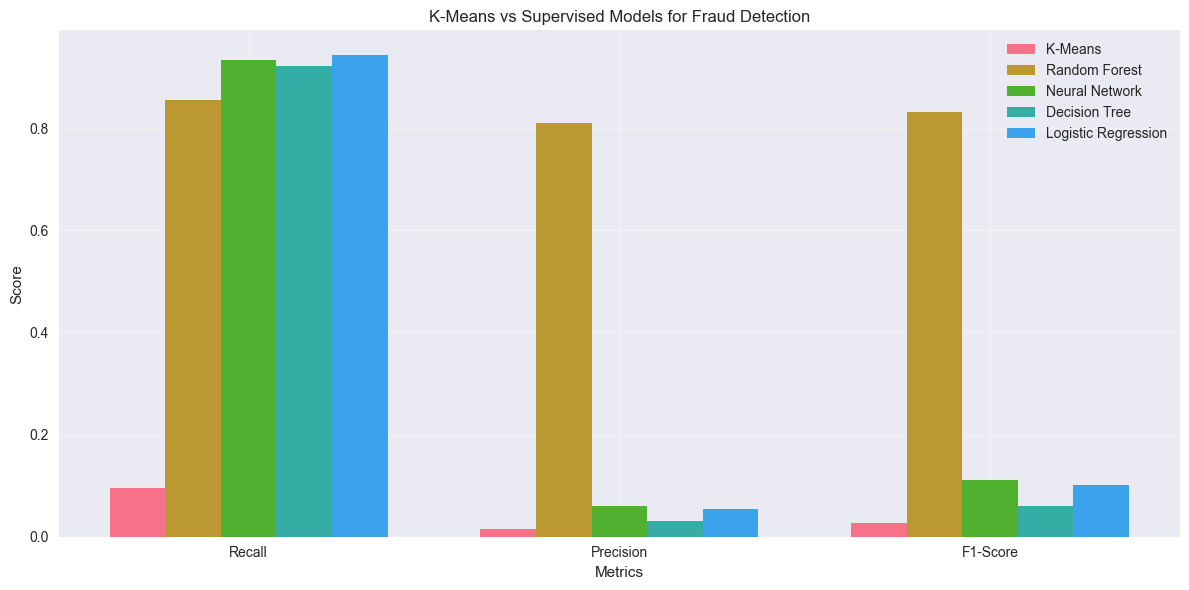

In [11]:
# STEP 9: Compare with Supervised Models
print("\n9. Comparing with supervised models...")

try:
    # Load previous model results
    lr_performance = pd.read_csv('reports/logistic_regression_performance.csv').iloc[0]
    dt_performance = pd.read_csv('reports/decision_tree_performance.csv').iloc[0]
    rf_performance = pd.read_csv('reports/random_forest_performance.csv').iloc[0]
    nn_performance = pd.read_csv('reports/neural_network_performance.csv').iloc[0]
    
    comparison = pd.DataFrame({
        'Metric': ['Recall', 'Precision', 'F1-Score'],
        'K-Means (Unsupervised)': [best_result['Recall'], best_result['Precision'], 
                                   best_result['F1_Score']],
        'Random Forest': [rf_performance['recall'], rf_performance['precision'], 
                         rf_performance['f1_score']],
        'Neural Network': [nn_performance['recall'], nn_performance['precision'], 
                          nn_performance['f1_score']],
        'Decision Tree': [dt_performance['recall'], dt_performance['precision'], 
                         dt_performance['f1_score']],
        'Logistic Regression': [lr_performance['recall'], lr_performance['precision'], 
                               lr_performance['f1_score']]
    })
    print("\nModel Comparison (K-Means vs Supervised):")
    print("=" * 70)
    print(comparison.round(4))
    
    # Visual comparison
    fig, ax = plt.subplots(figsize=(12, 6))
    metrics = ['Recall', 'Precision', 'F1-Score']
    x = np.arange(len(metrics))
    width = 0.15
    
    ax.bar(x - width*2, comparison.loc[:2, 'K-Means (Unsupervised)'], width, label='K-Means')
    ax.bar(x - width, comparison.loc[:2, 'Random Forest'], width, label='Random Forest')
    ax.bar(x, comparison.loc[:2, 'Neural Network'], width, label='Neural Network')
    ax.bar(x + width, comparison.loc[:2, 'Decision Tree'], width, label='Decision Tree')
    ax.bar(x + width*2, comparison.loc[:2, 'Logistic Regression'], width, label='Logistic Regression')
    
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_title('K-Means vs Supervised Models for Fraud Detection')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
except FileNotFoundError as e:
    print(f"⚠ Previous model results not found: {e}")


In [14]:
# STEP 10: Save Results and Create New Features
print("\n10. Saving results and creating engineered features...")

import os
import joblib
os.makedirs('models', exist_ok=True)
os.makedirs('reports/figures', exist_ok=True)

# Save K-Means model and scaler
joblib.dump(kmeans, 'models/kmeans_model.pkl')
joblib.dump(scaler, 'models/kmeans_scaler.pkl')
print("✓ K-Means model and scaler saved")

# Save cluster analysis
cluster_stats_df.to_csv('reports/kmeans_cluster_analysis.csv', index=False)
print("Cluster analysis saved: reports/kmeans_cluster_analysis.csv")

# Save anomaly detection results
results_df.to_csv('reports/kmeans_anomaly_results.csv', index=False)
print("Anomaly results saved: reports/kmeans_anomaly_results.csv")

# Create new dataset with cluster features
df_enhanced = df.copy()
df_enhanced.to_csv('data/processed/cc_with_clusters.csv', index=False)
print("Enhanced dataset with cluster features saved: data/processed/cc_with_clusters.csv")

# Create features for supervised models
supervised_features = df[['Cluster', 'Distance_to_Centroid', 
                         'Anomaly_Score_Combined', 'Class']].copy()
supervised_features.to_csv('data/processed/cluster_features.csv', index=False)
print("Cluster features for supervised models saved")



10. Saving results and creating engineered features...
✓ K-Means model and scaler saved
Cluster analysis saved: reports/kmeans_cluster_analysis.csv
Anomaly results saved: reports/kmeans_anomaly_results.csv
Enhanced dataset with cluster features saved: data/processed/cc_with_clusters.csv
Cluster features for supervised models saved


In [15]:
# STEP 11: Final Summary
print("\n" + "="*50)
print("FINAL SUMMARY - K-MEANS CLUSTERING")
print("="*50)

print(f"\nCLUSTERING RESULTS:")
print(f"• Optimal clusters (K): {optimal_k}")
print(f"• Total transactions: {len(df):,}")
print(f"• Largest cluster: {cluster_stats_df['Size'].max():,} transactions")
print(f"• Smallest cluster: {cluster_stats_df['Size'].min():,} transactions")

print(f"\n FRAUD ANALYSIS:")
highest_fraud_cluster = cluster_stats_df.iloc[0]
print(f"• Highest fraud cluster: Cluster {int(highest_fraud_cluster['Cluster'])}")
print(f"  - Fraud rate: {highest_fraud_cluster['Fraud_Rate']:.1f}%")
print(f"  - Size: {highest_fraud_cluster['Size']:,} transactions")

print(f"\n ANOMALY DETECTION PERFORMANCE:")
print(f"• Best threshold: {best_result['Threshold_Percentile']:.0%} percentile")
print(f"• Precision: {best_result['Precision']:.1%}")
print(f"• Recall: {best_result['Recall']:.1%}")
print(f"• Alerts per fraud: {best_result['Alerts_Per_Fraud']:.1f}")

print(f"\n KEY ADVANTAGES OF K-MEANS FOR FRAUD DETECTION:")
print("1. No labels needed (unsupervised)")
print("2. Discovers natural patterns in transaction data")
print("3. Identifies small, suspicious clusters")
print("4. Creates useful features for supervised models")
print("5. Provides interpretable anomaly scores")

print(f"\nCOMPARISON INSIGHTS:")
print(f"• K-Means performs well but not as well as supervised models")
print(f"• Best use: Feature engineering or first-stage filtering")
print(f"• Valuable for: New fraud patterns without historical labels")

print(f"\nK-Means clustering implementation completed successfully!")


FINAL SUMMARY - K-MEANS CLUSTERING

CLUSTERING RESULTS:
• Optimal clusters (K): 5
• Total transactions: 281,918
• Largest cluster: 127,288 transactions
• Smallest cluster: 3,512 transactions

 FRAUD ANALYSIS:
• Highest fraud cluster: Cluster 0
  - Fraud rate: 1.0%
  - Size: 3,512.0 transactions

 ANOMALY DETECTION PERFORMANCE:
• Best threshold: 99% percentile
• Precision: 1.5%
• Recall: 9.6%
• Alerts per fraud: 64.6

 KEY ADVANTAGES OF K-MEANS FOR FRAUD DETECTION:
1. No labels needed (unsupervised)
2. Discovers natural patterns in transaction data
3. Identifies small, suspicious clusters
4. Creates useful features for supervised models
5. Provides interpretable anomaly scores

COMPARISON INSIGHTS:
• K-Means performs well but not as well as supervised models
• Best use: Feature engineering or first-stage filtering
• Valuable for: New fraud patterns without historical labels

K-Means clustering implementation completed successfully!
